# **2020 하계 프로젝트 #1-1**

* Eveing 스터디 2020년 하계 방학 개인 프로젝트 # 1-1
* 개발기간 : 2020.07.22~
* 주제 : 3 Pokemon dataset을 이용한 기초 VAE 연습
* 결과 : tensorflow 버전차이인지 알 수 없는 원인으로 인해 모델학습불가..
* 보완 : 프로젝트 1-2에서는 keras가 아닌 pytorch로 다시 구성해볼 예정

## **settings**

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=False)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import tensorflow as tf


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf


# 텐서플로우 2.0 으로 업그레이드 후 발생하는 eager execution Runtime Error 방지용 코드


from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time

import keras
from keras import backend as K
from keras.layers import Layer
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint 
from keras.optimizers import Adam

from tensorflow.python.framework import ops

In [ ]:
np.random.seed(0)
 
data_dir = '/content/gdrive/My Drive/Colab Notebooks/vae_project/Pokemon-dataset/'
train_path = '/content/gdrive/My Drive/Colab Notebooks/vae_project/Pokemon-dataset/train'
test_path = '/content/gdrive/My Drive/Colab Notebooks/vae_project/Pokemon-dataset/test'

## **data**

In [ ]:
img_shape = (128, 128, 3)
batch_size = 32

import os
from glob import glob

filenames = np.array(glob(os.path.join(data_dir, '*/*/*.jpg'))) # dataset->train->pikachu->397.jpg 형식이므로 총 3번 들어감

num_images = len(filenames)
print(num_images)

492


In [ ]:
# keras 이미지 전처리 라이브러리
from keras import preprocessing
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator # https://keras.io/ko/preprocessing/image/
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
# Generator
# imshow는 0-1 float 또는 0-255 int 로 input해야하기 때문에 255로 나눔
def my_preprocessing_func(img):
    image = np.array(img)
    return image / 255

data_gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True, 
       preprocessing_function = my_preprocessing_func)

# Get Batches
# 폴더별로 라벨링하면서 읽어들임
train_flow = data_gen.flow_from_directory(train_path
                                         , target_size = img_shape[:2]
                                         , batch_size = batch_size
                                         , shuffle = True
                                         , class_mode = 'categorical'
                                         , subset = "training"
                                            )

train_image_batch, train_labels_batch = next(train_flow)

Found 303 images belonging to 3 classes.


Dataset Checking


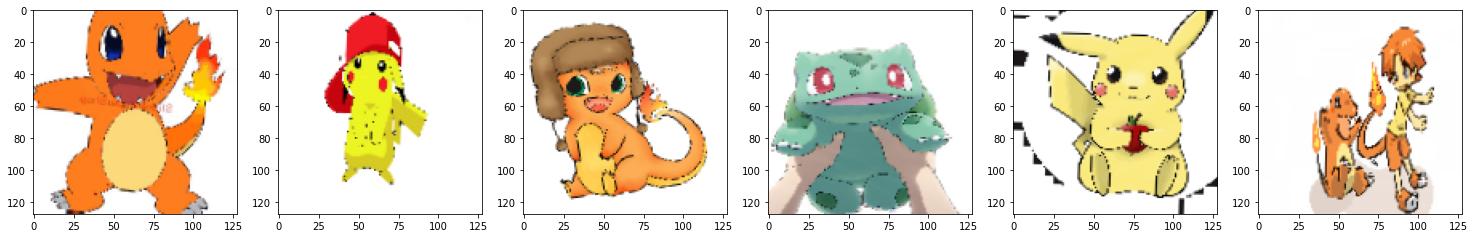

In [ ]:
# Plot Images

print("Dataset Checking")
fig = plt.figure(figsize=(30,10))
nplot = 7

for count in range (1, nplot):
  ax = fig.add_subplot(1,nplot,count)
  image = train_image_batch[count]
  ax.imshow(image)

plt.show()
plt.close()

# Generator 사용하지 않고 testSet 구성해보기

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(28, 28),
  label_mode='int',
  color_mode='rgb',
  batch_size=1)

Found 123 files belonging to 3 classes.


In [ ]:
# input shape 확인
test_ds

<BatchDataset shapes: ((None, 28, 28, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
test=[]
for image_batch, labels_batch in test_ds:
  ts=tf.convert_to_tensor(image_batch)
  ts=tf.data.Dataset.from_tensor_slices(ts)
  test.append(list(ts))

In [ ]:
print(len(test))

123


In [ ]:
test[0][0].shape

TensorShape([28, 28, 3])

Dataset Checking


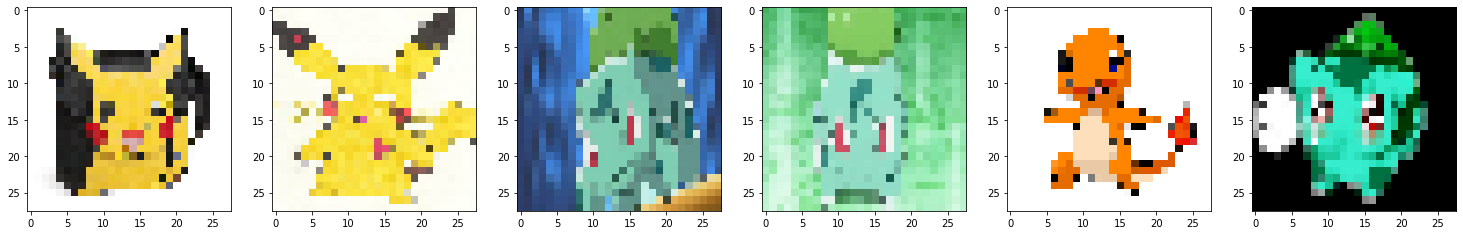

In [ ]:
print("Dataset Checking")
fig = plt.figure(figsize=(30,10))
nplot = 7
for count in range(1, nplot):
  ax = fig.add_subplot(1,nplot,count)
  image = img_to_array(test[count][0])/255.
  ax.imshow(image) # test[count]로만 하면 오류발생 뒤에 인덱스도 0으로 맞춰야하는듯

plt.show()
plt.close()

In [ ]:
def setData(dataSet):
  data = []
  for count in range(0, len(dataSet)):
    image = img_to_array(dataSet[count][0])/255. 
    data.append(image)

  return np.array(data)

In [ ]:
testSet = setData(test)
print("Test data shape: {}".format(testSet.shape))

Test data shape: (123, 28, 28, 3)


## **VAE model**

In [ ]:
class VAE():
    def __init__(self,
                input_dim,
                Encoder_layer_num,
                Encoder_filters,
                Encoder_kernels,
                Encoder_strides,
                latent_dim,
                Decoder_layer_num,
                Decoder_filters,
                Decoder_kernels,
                Decoder_strides,
                Decoder_batch_norm = True,
                Decoder_dropout = True
                ):
        self.name = 'variational_autoencoder'

        self.input_dim = input_dim
        self.size = self.input_dim
        self.latent_dim = latent_dim
        self.n_layers_encoder = Encoder_layer_num
        self.encoder_conv_filters = Encoder_filters
        self.encoder_conv_kernels = Encoder_kernels
        self.encoder_conv_strides = Encoder_strides

        self.n_layers_decoder =Decoder_layer_num
        self.use_batch_norm = Decoder_batch_norm
        self.use_dropout = Decoder_dropout
        self.decoder_conv_filters = Decoder_filters
        self.decoder_conv_kernels = Decoder_kernels
        self.decoder_conv_strides = Decoder_strides
        
        self._build()

    def _build(self):
      ## 인코더
        encoder_input = Input(shape=self.input_dim, name='Encoder_Input')
        x = encoder_input

        for i in range(self.n_layers_encoder):
            encoder_conv = Conv2D(
                filters = self.encoder_conv_filters[i],
                kernel_size = self.encoder_conv_kernels[i],
                strides = self.encoder_conv_strides[i],
                padding = 'same',
                name = "encoder_conv_" + str(i)
            )

            x = encoder_conv(x)

            if self.use_batch_norm:
              x = BatchNormalization()(x)

            x = LeakyReLU()(x)
            if self.use_dropout:
              x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)

        self.mean = Dense(self.latent_dim, name='Mean')(x)
        self.log_var = Dense(self.latent_dim, name="Log_Var")(x)
        self.encoder_mu_log_var = Model(encoder_input, (self.mean, self.log_var))

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon

        encoder_output = Lambda(sampling, name='Encoder_output')([self.mean, self.log_var])

        self.encoder = Model(encoder_input, encoder_output)
    

      ## 디코더
        decoder_input = Input(shape=(self.latent_dim,), name='Decodeer_Input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            decoder_convT = Conv2DTranspose(
                filters = self.decoder_conv_filters[i],
                kernel_size = self.decoder_conv_kernels[i],
                strides = self.decoder_conv_strides[i],
                padding = 'same',
                name = "Decoder_convT_" + str(i)
            )

            x = decoder_convT(x)

            if i < self.n_layers_decoder - 1:
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x
        self.decoder = Model(decoder_input, decoder_output)
        
        # Full VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)

    def compile(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return r_loss_factor * r_loss

        def vae_kl_loss(y_true, y_pred):
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis = 1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = Adam(lr=learning_rate, beta_1=0.5, epsilon=1e-5)
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])

    
    def save(self, saveDir):
        curtime = time.strftime("%Y%m%d_%H%M%S", time.gmtime(time.time()))
        saveDir = os.path.join(saveDir, curtime)
        if not os.path.exists(saveDir):
            os.mkdir(saveDir)
        self.model.save(saveDir + "/model.h5", overwrite=True)

    def train(self, x_train, batch_size, epochs, initial_epoch = 0):

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
        )

    def train_with_generator(self, data_flow,  epochs, steps_per_epoch, initial_epoch = 0):

        self.model.fit_generator(
            data_flow
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , steps_per_epoch=steps_per_epoch 
            )


    def test(self, trainSet):
        fig = plt.figure(figsize=(30,10))
        nplot = [10, 10]
        latent_space = []

        for j in range(0, nplot[0], 2):
            for i in range(nplot[1]):
                count = np.random.randint(0, len(trainSet), 1)
                ax = fig.add_subplot(nplot[0], nplot[1], j * nplot[1] + i + 1)
                ax.imshow(trainSet[count[0]])
                ax.axis('off')

                latent_space.append(self.encoder.predict(np.expand_dims(trainSet[count[0]], 0)))
                ax = fig.add_subplot(nplot[0], nplot[1], (j+1) * nplot[1] + i + 1)
                ax.imshow(np.squeeze(self.model.predict(np.expand_dims(trainSet[count[0]], 0)), 0))
                ax.axis('off')             
        plt.show()
        plt.close()

        return latent_space

In [ ]:
 gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      logical_gpus = tf.config.experimental.list_logical_devices('GPU')
      print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
      # Memory growth must be set before GPUs have been initialized
      print(e)

config = tf.compat.v1.ConfigProto(log_device_placement=True, allow_soft_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.4

print("Training with GPU? ==> [", tf.test.is_built_with_gpu_support(), "]")

Training with GPU? ==> [ True ]


## **architecture**

In [ ]:
img_shape = (128, 128, 3)
VAE = VAE(
            img_shape,
            4,
            [32, 32, 64, 128],
            [3, 3, 3, 3],
            [1, 2, 2, 1],
            10,
            4,
            [128, 64, 32, 3],
            [3, 3, 3, 3],
            [1, 2, 2, 1],
            Decoder_batch_norm=True,
            Decoder_dropout=True
    )
print(VAE.encoder.summary())
print(VAE.decoder.summary())


Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_Input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 128, 128, 32) 896         Encoder_Input[0][0]              
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 128, 128, 32) 128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_14 (LeakyReLU)      (None, 128, 128, 32) 0           batch_normalization_14[0][0]     
______________________________________________________________________________________

## **training**

In [ ]:
learning_rate = 0.0005
r_loss_factor = 10000
epochs = 30
initial_epoch = 0

In [ ]:
VAE.compile(learning_rate, r_loss_factor)

In [ ]:
print("Start Training with Device: {}".format(tf.test.gpu_device_name()))

VAE.train_with_generator(     
   train_flow
    , epochs = epochs
    , steps_per_epoch = num_images / batch_size
    , initial_epoch = initial_epoch
)
VAE.save("/content/gdrive/My Drive/Colab Notebooks/vae_project/Pokemon_Model/")
VAE.test(testSet)

Start Training with Device: 
Epoch 1/30


_SymbolicException: ignored